In [0]:
%matplotlib inline

In [2]:
! pip freeze

beautifulsoup4==4.6.0
bleach==1.5.0
cachetools==2.0.1
certifi==2018.1.18
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
decorator==4.2.1
dill==0.2.7.1
entrypoints==0.2.3
enum34==1.1.6
future==0.15.2
futures==3.0.5
gapic-google-cloud-datastore-v1==0.15.3
gapic-google-cloud-error-reporting-v1beta1==0.15.3
gapic-google-cloud-logging-v2==0.91.3
google-api-core==0.1.4
google-api-python-client==1.6.5
google-auth==1.3.0
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud==0.32.0
google-cloud-bigquery==0.28.0
google-cloud-bigquery-datatransfer==0.1.0
google-cloud-bigtable==0.28.1
google-cloud-container==0.1.0
google-cloud-core==0.28.0
google-cloud-datastore==1.4.0
google-cloud-dns==0.28.0
google-cloud-error-reporting==0.28.0
google-cloud-firestore==0.28.0
google-cloud-language==1.0.0
google-cloud-logging==1.4.0
google-cloud-monitoring==0.28.0
google-cloud-pubsub==0.30.1
google-cloud-resource-manager==0.28.0
google-cloud-runtimeconfig==0.28.0
google-cloud-spanner==0.29.0
google-clou

In [3]:
! pip install http://download.pytorch.org/whl/cu80/torch-0.2.0.post3-cp36-cp36m-manylinux1_x86_64.whl torchvision==0.1.8

    100% |████████████████████████████████| 486.7MB 91.7MB/s 



Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




![](https://lh6.googleusercontent.com/1DiWS799xjvO-d_OjZfPWZAetishY2sDH_uwUOHmkJZ2AnWu1d1To8JaU_823utjcJdJ-IFZ9p2LwUOr1PGD=w1920-h898-rw)

![](https://lh3.googleusercontent.com/54n2s0gh8_6xD-wdXBrRZv94T2SfHT9PyOu5TfXqnjISQHEmOIHOFtV-7u3-xaIrPac4-HucTh2l4Z-StCMX=w1920-h898-rw)

![](https://lh4.googleusercontent.com/0Yq8KtZNt02n5dGxYcyG5OS5Yn_vlznRDIm3glltXlk5AmSFwd0R9bXiWZpx0aMsRVEuhIm-TdiuXZlulNem=w1920-h898-rw)

![](https://lh6.googleusercontent.com/eGmCvlm0geCFF8d0JjL4dIJBUF7hKPN9kjGqCnVMSiFSg_JByLkkAPCo-1wqvcu-3JY_zN3wMd1_XJ9nKnPF=w1920-h898-rw)

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
use_gpu = torch.cuda.is_available()

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
! wget -O hymenoptera_data.zip "https://download.pytorch.org/tutorial/hymenoptera_data.zip" && unzip hymenoptera_data.zip

--2018-02-03 14:46:10--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.201.28, 52.222.201.52, 52.222.201.246, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.201.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  10.7MB/s    in 8.8s    

2018-02-03 14:46:20 (5.13 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_da


  inflating: hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  
  inflating: hymenoptera_data/val/bees/1355974687_1341c1face.jpg  
  inflating: hymenoptera_data/val/bees/144098310_a4176fd54d.jpg  
  inflating: hymenoptera_data/val/bees/1486120850_490388f84b.jpg  
  inflating: hymenoptera_data/val/bees/149973093_da3c446268.jpg  
  inflating: hymenoptera_data/val/bees/151594775_ee7dc17b60.jpg  
  inflating: hymenoptera_data/val/bees/151603988_2c6f7d14c7.jpg  
  inflating: hymenoptera_data/val/bees/1519368889_4270261ee3.jpg  
  inflating: hymenoptera_data/val/bees/152789693_220b003452.jpg  
  inflating: hymenoptera_data/val/bees/177677657_a38c97e572.jpg  
  inflating: hymenoptera_data/val/bees/1799729694_0c40101071.jpg  
  inflating: hymenoptera_data/val/bees/181171681_c5a1a82ded.jpg  
  inflating: hymenoptera_data/val/bees/187130242_4593a4c610.jpg  
  inflating: hymenoptera_data/val/bees/203868383_0fcbb48278.jpg  
  i

In [7]:
! ls

datalab  hymenoptera_data  hymenoptera_data.zip


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [9]:
print(dataset_sizes)

{'train': 244, 'val': 153}


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



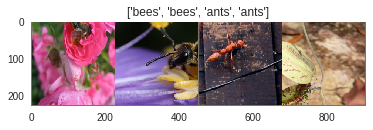

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
13.9%

100.0%


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5786 Acc: 0.7213
val Loss: 0.2513 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5789 Acc: 0.7459
val Loss: 0.5858 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.6539 Acc: 0.7664
val Loss: 0.4237 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.5093 Acc: 0.8156
val Loss: 0.4984 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.7487 Acc: 0.7336
val Loss: 0.6354 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.6334 Acc: 0.7582
val Loss: 0.2857 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5773 Acc: 0.7992
val Loss: 0.2511 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3891 Acc: 0.8484
val Loss: 0.2973 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.4882 Acc: 0.7951
val Loss: 0.2751 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3357 Acc: 0.8648
val Loss: 0.2570 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2531 Acc: 0.9098
val Loss: 0.2439 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3601 Acc: 0.8525
val Loss: 0.2339 Acc: 0.9216

Ep

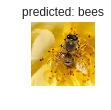

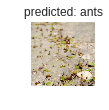

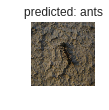

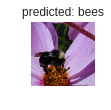

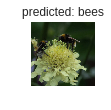

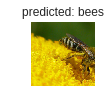

In [15]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True).eval()
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5713 Acc: 0.7131
val Loss: 0.2728 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5114 Acc: 0.7418
val Loss: 0.1810 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3879 Acc: 0.8361
val Loss: 0.1606 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3609 Acc: 0.8115
val Loss: 0.1778 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5170 Acc: 0.7746
val Loss: 0.2681 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3732 Acc: 0.8074
val Loss: 0.2051 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5104 Acc: 0.7992
val Loss: 0.1614 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.2799 Acc: 0.8893
val Loss: 0.1609 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3721 Acc: 0.8402
val Loss: 0.1706 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3640 Acc: 0.8811
val Loss: 0.1645 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2937 Acc: 0.8852
val Loss: 0.1596 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3204 Acc: 0.8770
val Loss: 0.1673 Acc: 0.9542

Ep

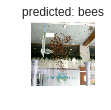

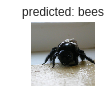

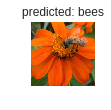

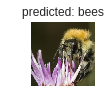

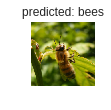

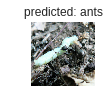

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## **Feature Representation By Manifold Learning **

We want to know what has been learnt for those images by ResNet.

One can also extract features from resnet18 and save it in .txt file for our explorations.

In this notebook we would like to take some feature representation examples by some popular methods such as PCA/MDS/tSNE

In [7]:
model_ft = models.resnet18(pretrained=True).eval()
if use_gpu:
    model_ft=model_ft.cuda()
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
13.9%

100.0%


512


In [10]:
print(model_ft)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Now extract 512-features as the network output after removing the last fc layer.

Getting all the features of the training data which will be used for Manifold Learning.

In [8]:
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)


features_train=[]
features_val=[]
classes_train=[]
classes_val=[]
for data in ['train','val']:
    for i,(images,labels) in enumerate(dataloaders[data]):
        img=Variable(images)
        if use_gpu:
            img=img.cuda()
        out=resnet18_feature.forward(img)
        out=out.view(-1,512).cpu().data.numpy()
        labels=labels.numpy()
        if data=='train':
            features_train.append(out)
            classes_train.append(labels)
        else:
            features_val.append(out)
            classes_val.append(labels)
features_train=np.vstack(features_train)
classes_train=np.hstack(classes_train)
features_val=np.vstack(features_val)
classes_val=np.hstack(classes_val)

print('train features size:{}\tlabels size:{}'.format(features_train.shape,classes_train.shape))
print('val features size:{}\tlabels size:{}'.format(features_val.shape,classes_val.shape))

train features size:(244, 512)	labels size:(244,)
val features size:(153, 512)	labels size:(153,)


Here, we compare 8 popular methods in Manifold Learning:

PCA,Isomap,MDA,tSNE,LLE,LTSA,Hessian LLE,Modified LLE

LLE starts......
LTSA starts......
Hessian LLE starts......
Modified LLE starts......
Isomap starts......
MDS starts......
TSNE starts......
PCA starts......


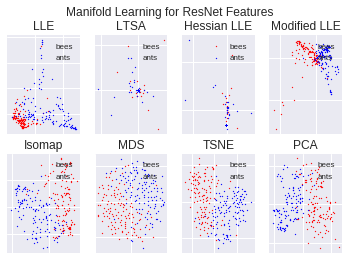

In [9]:
import seaborn
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding

LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                    ['standard', 'ltsa', 'hessian', 'modified']))
methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']

fig_features=plt.figure(1)
fig_features.suptitle('Manifold Learning for ResNet Features')

for i,method in enumerate(methods):
    print('{} starts......'.format(method))
    if method in LLE_dict.keys():
        manifold=LocallyLinearEmbedding(n_neighbors=6,method=LLE_dict[method],eigen_solver='dense')
    elif method=='MDS':
        manifold=MDS(n_init=1,max_iter=100)
    elif method=='PCA':
        exec('manifold={}(n_components=2)'.format(method))
    elif method=='TSNE':
        exec('manifold={}(n_components=2,init="pca")'.format(method))
    else:
        exec('manifold={}(n_neighbors=6)'.format(method))
    features_2D=manifold.fit_transform(features_train)
    np.save('features_2d_{}'.format(method),features_2D)
    
    ax=fig_features.add_subplot(241+i)
    ax.scatter(features_2D[np.where(classes_train==1),0],features_2D[np.where(classes_train==1),1],s=1,c='r',label='bees')
    ax.scatter(features_2D[np.where(classes_train==0),0],features_2D[np.where(classes_train==0),1],s=1,c='b',label='ants')
    ax.legend(loc='upper right',prop={'size':8})
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    
fig_features.savefig('Manifold_of_ResNet.png')


Now we test some traditional Machine Learning methods such Logistic Regression and SVM by using the ResNet features.

Then we can make a comparion between Machine Learning and Deep Learning.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score


accuracy_train=[]
accuracy_val=[]
for method in ['LogisticRegression','LinearSVC']:
    print('%s starts...' % method)
    if method=='LogisticRegression':
        exec('transformation=%s(penalty="l2")' % method)
    else:
        exec('transformation=%s(penalty="l2")' % method)
    transformation.fit(features_train,classes_train)
    pred_train=transformation.predict(features_train)
    pred_val=transformation.predict(features_val)
    accuracy_train.append(accuracy_score(classes_train,pred_train))
    accuracy_val.append(accuracy_score(classes_val,pred_val))
    print('training accuracy:{:.4f}\t val accuracy:{:.4f}'.format(accuracy_train[-1],accuracy_val[-1]))


LogisticRegression starts...
training accuracy:1.0000	 val accuracy:0.9477
LinearSVC starts...
training accuracy:1.0000	 val accuracy:0.9542


# **CNN layer Visualization**

Finally, we want to know what partten had been learnt in ResNet18 CNN layer.

In [11]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Selecting previously unselected package libxext6:amd64.
(Reading database ... 16633 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d 

In [0]:
import cv2

def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [0]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im

In [0]:
np.random.seed(0)

class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Create the folder to export images if not exists
        if not os.path.exists('./generated'):
            os.makedirs('./generated')

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image)
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas later layers need less
        optimizer = optim.SGD([self.processed_image], lr=10, weight_decay=1e-6)
        for i in range(1, 51):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)+torch.mean(self.processed_image**2)
            if i%10==0:
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()[0]))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image
            if i % 5 == 0:
                cv2.imwrite('./generated/layer_vis_l' + str(self.selected_layer) +
                            '_f' + str(self.selected_filter) + '_iter'+str(i)+'.jpg',
                            self.created_image)
        
        plt.grid(False)    
        plt.title('CNN layer {} Visualization'.format(self.selected_layer))
        plt.imshow(self.created_image)
        plt.pause(0.01)
 

CNN layer:5
Iteration: 10 Loss: 0.64
Iteration: 20 Loss: 0.58
Iteration: 30 Loss: 0.53
Iteration: 40 Loss: 0.50
Iteration: 50 Loss: 0.47


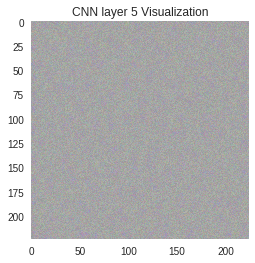

CNN layer:6
Iteration: 10 Loss: -0.32
Iteration: 20 Loss: -0.76
Iteration: 30 Loss: -1.02
Iteration: 40 Loss: -1.23
Iteration: 50 Loss: -1.39


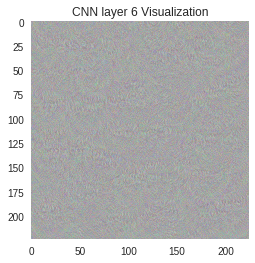

CNN layer:7
Iteration: 10 Loss: -19.80
Iteration: 20 Loss: -39.70
Iteration: 30 Loss: -54.45
Iteration: 40 Loss: -65.40
Iteration: 50 Loss: -75.43


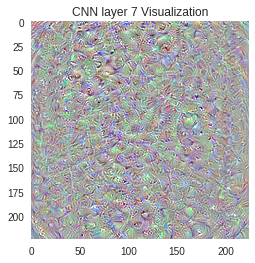

In [15]:
filter_pos = 0
for cnn_layer in [5,6,7]:
    print('CNN layer:{}'.format(cnn_layer))
    # Fully connected layer is not needed
    layer_vis = CNNLayerVisualization(resnet18_feature.cpu(), cnn_layer, filter_pos)

    # Layer visualization without pytorch hooks
    layer_vis.visualise_layer_without_hooks()
plt.ioff()
plt.show()

# **DeepDream**

In [0]:
import PIL.Image
from io import BytesIO
from IPython.display import clear_output,Image,display
import numpy as np


def showarray(a,fmt='jpeg'):
    a=np.uint8(np.clip(a,0,255))
    f=BytesIO()
    PIL.Image.fromarray(a).save(f,fmt)
    display(Image(data=f.getvalue()))

def showtensor(a):
    mean=np.array([0.485,0.456,0.406]).reshape([1,1,3])
    std=np.array([0.229,0.224,0.225]).reshape([1,1,3])
    inp=a[0,:,:,:]
    inp=inp.transpose(1,2,0)
    inp=(inp*std+mean)*225
    showarray(inp)
    clear_output(wait=True)

In [0]:
import torch
import scipy.ndimage as nd
from torch.autograd import Variable
from torchvision import models,transforms

use_cuda=torch.cuda.is_available()

def objective_L2(dst,guide_features):
    return dst

def dream(model,base_img,selected_layer,octave_n=6,octave_scale=1.4,control=None,distance=objective_L2):
    octaves=[base_img]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1],(1,1,1/octave_scale,1/octave_scale),order=1))

    detail=np.zeros_like(octaves[-1])

    for octave,octave_base in enumerate(octaves[::-1]):
        h,w=octave_base.shape[-2:]
        if octave>0:
            h1,w1=detail.shape[-2:]
            detail=nd.zoom(detail,(1,1,h/h1,w/w1),order=1)

        input_oct=octave_base+detail
        print(input_oct.shape)
        out=make_step(input_oct,model,selected_layer,control,distance=distance)
        detail=out-octave_base

def make_step(img,model,selected_layer,control=None,distance=objective_L2):
    mean=np.array([0.485, 0.456, 0.406]).reshape([3,1,1])
    std=np.array([0.229, 0.224, 0.225]).reshape([3,1,1])

    lr=2e-2
    max_jitter=32
    num_iterations=30
    show_every=10
    end_layer=selected_layer
    guide_features=control

    for i in range(num_iterations):
        shift_x,shift_y=np.random.randint(-max_jitter,max_jitter+1,2)
        img=np.roll(np.roll(img,shift_x,-1),shift_y,-2)

        model.zero_grad()
        img=Variable(torch.from_numpy(img).float().cuda(),requires_grad=True)

        output=img
        for index,layer in enumerate(model):
            output=layer(output)
            if index==end_layer:
                break

        different=distance(output,guide_features)

        output=output*different
        loss=torch.sum(output)
        loss.backward()

        ratio=np.abs(img.grad.data.cpu().numpy()).mean()
        img.data.add_(img.grad.data*(lr/ratio))
        img=img.cpu().data.numpy()

        img=np.roll(np.roll(img,-shift_x,-1),-shift_y,-2)
        img[0,:,:,:]=np.clip(img[0,:,:,:],-mean/std,(1-mean)/std)

        if i==0 or (i+1)%show_every==0:
            showtensor(img)
    return img

In [0]:
pretrained_model = models.resnet18(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad=False
modules = list(pretrained_model.children())[:-1]
resnet18_feature = torch.nn.Sequential(*modules).cuda()

im_path = './hymenoptera_data/train/ants/0013035.jpg'

transformation=transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
image=PIL.Image.open(im_path)
image_tensor=transformation(image).unsqueeze(0)
image_np=image_tensor.numpy()


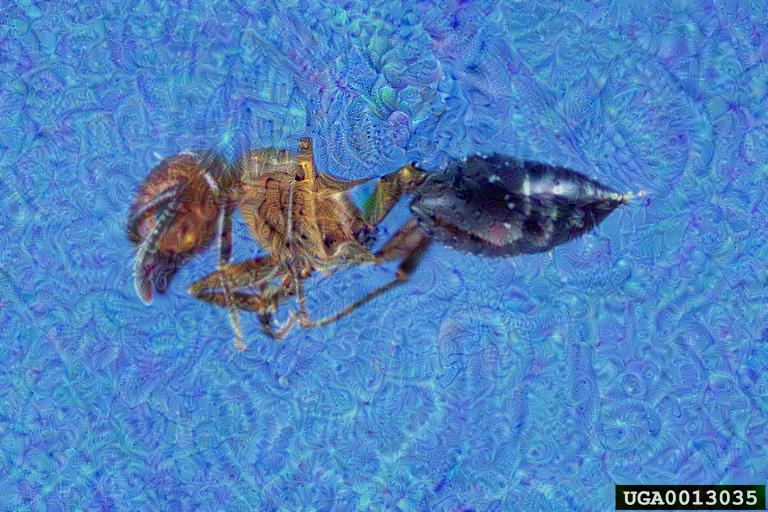

In [36]:
dream(resnet18_feature,image_np,selected_layer=7)

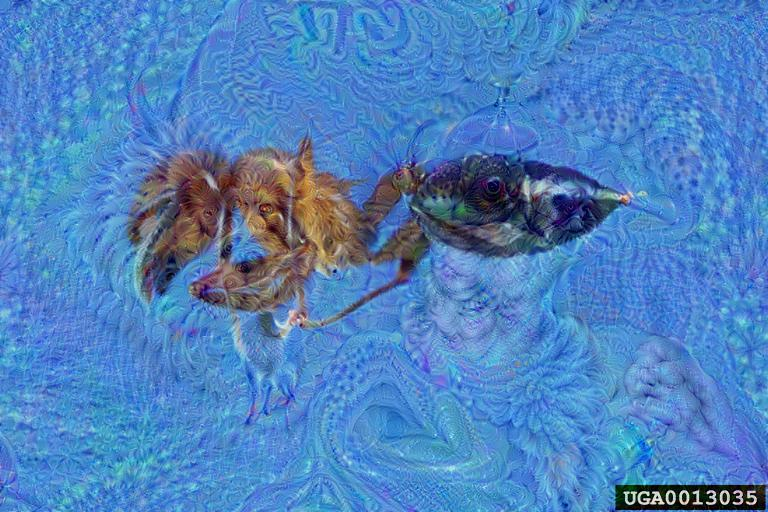

In [37]:
dream(resnet18_feature,image_np,selected_layer=6)

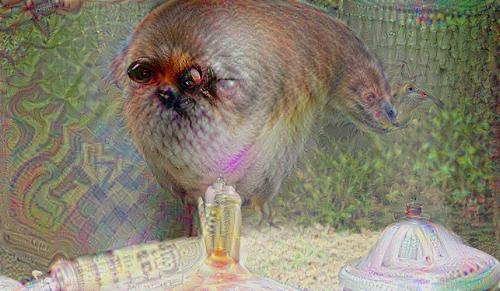

In [38]:
pretrained_model = models.resnet50(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad=False
modules = list(pretrained_model.children())[:-1]
resnet50_feature = torch.nn.Sequential(*modules).cuda()

im_path = './hymenoptera_data/train/bees/2467959963_a7831e9ff0.jpg'

transformation=transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
image=PIL.Image.open(im_path)
image_tensor=transformation(image).unsqueeze(0)
image_np=image_tensor.numpy()

dream(resnet50_feature,image_np,selected_layer=6)

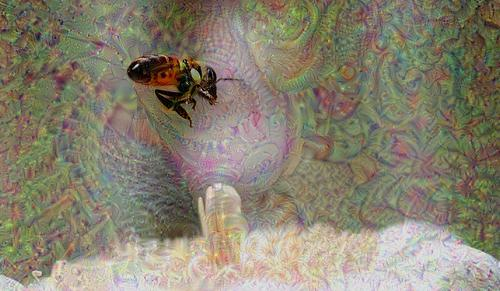

In [39]:
dream(resnet50_feature,image_np,selected_layer=7)

In [40]:
!wget -O sky.jpg 'https://raw.githubusercontent.com/google/deepdream/master/sky1024px.jpg'

--2018-02-03 15:06:38--  https://raw.githubusercontent.com/google/deepdream/master/sky1024px.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65049 (64K) [image/jpeg]
Saving to: ‘sky.jpg’

sky.jpg             100%[===================>]  63.52K  --.-KB/s    in 0.02s   

2018-02-03 15:06:38 (4.08 MB/s) - ‘sky.jpg’ saved [65049/65049]



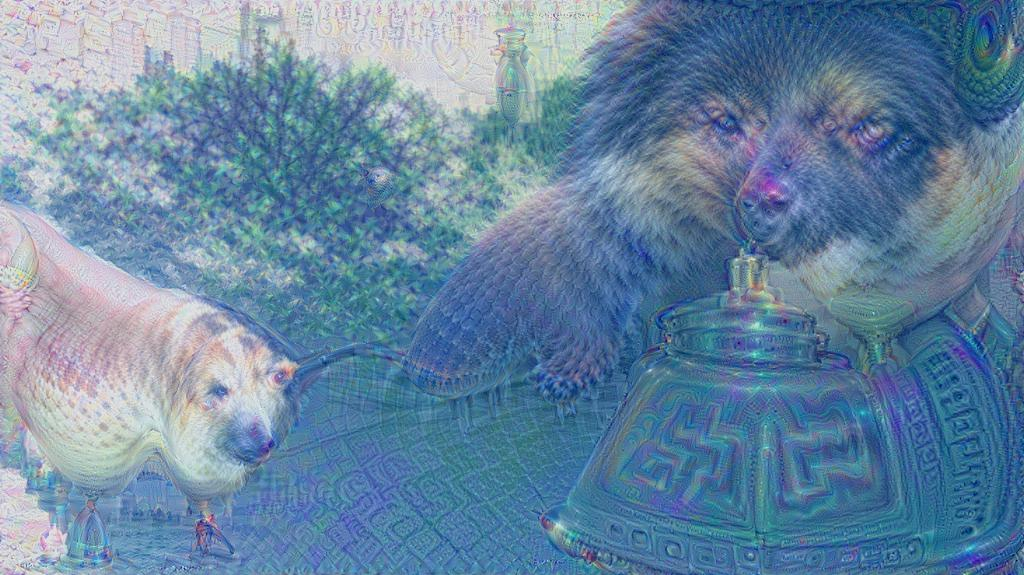

In [30]:
im_path = 'sky.jpg'

image=PIL.Image.open(im_path)
image_tensor=transformation(image).unsqueeze(0)
image_np=image_tensor.numpy()

dream(resnet50_feature,image_np,selected_layer=6)

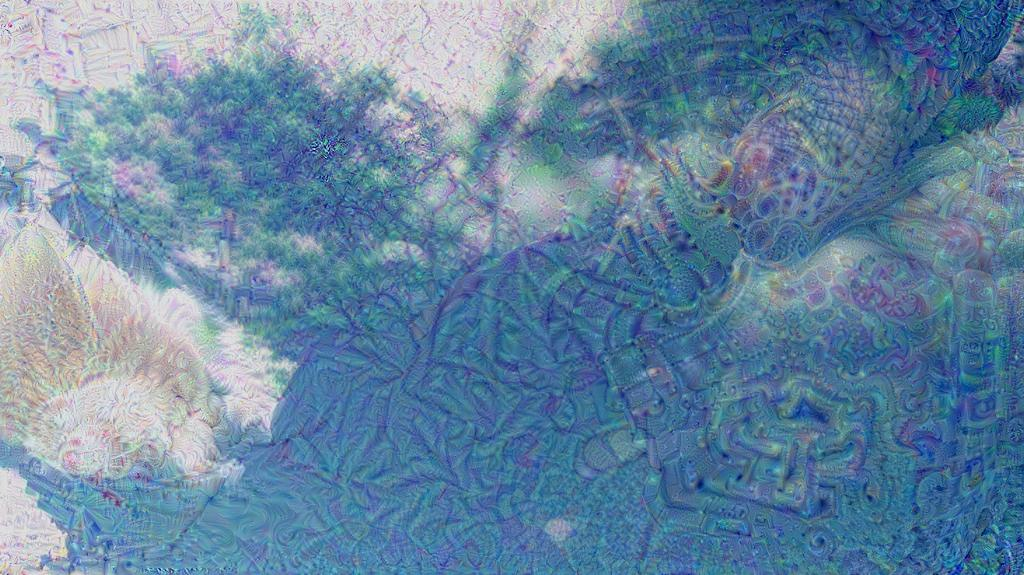

In [31]:
dream(resnet50_feature,image_np,selected_layer=7)

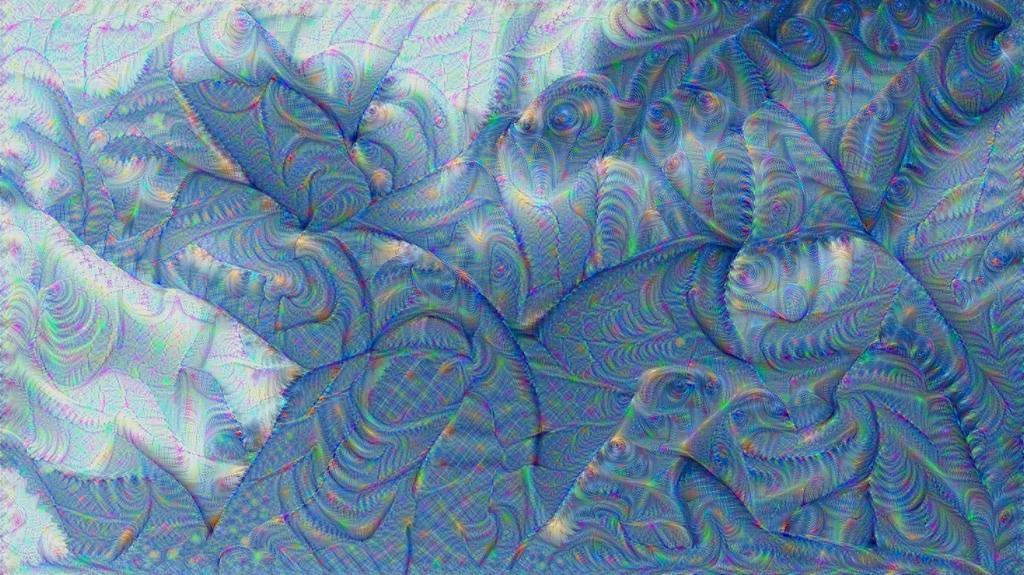

In [33]:
dream(resnet50_feature,image_np,selected_layer=5)

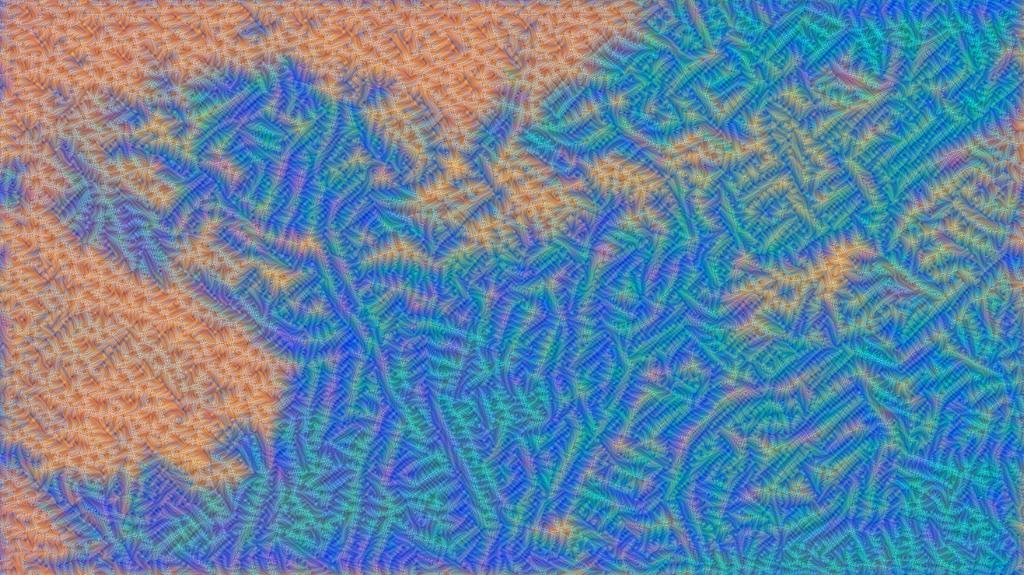

In [34]:
dream(resnet50_feature,image_np,selected_layer=4)